In [ ]:
# Basic Data Loading into the Thunder Context. Takes a DIR with individual .tifs.
# to do: Load in tif stack

In [35]:
%matplotlib inline

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')
from thunder import Colorize
image = Colorize.image

In [37]:
import os.path as pth
imagepath = pth.join(pth.dirname(pth.realpath(thunder.__file__)), '/Users/ARGO/Downloads/Examples For Processing /SONG_lowSNR1')


In [38]:
data = tsc.loadImages(imagepath, inputFormat='tif')

In [39]:
data



Images
nrecords: 165
dtype: None (inspect to compute)
dims: None (inspect to compute)

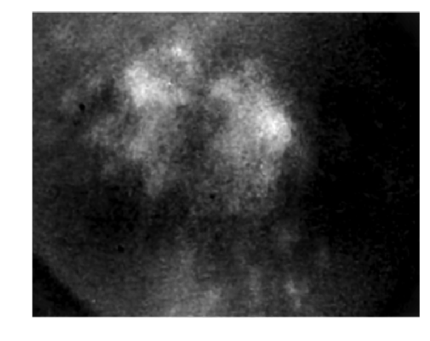

In [40]:
image(data[100])

In [41]:
data.dims.max

(559, 709)

In [42]:
sub = data.subsample([5,5,1])
img = sub.first()[1]

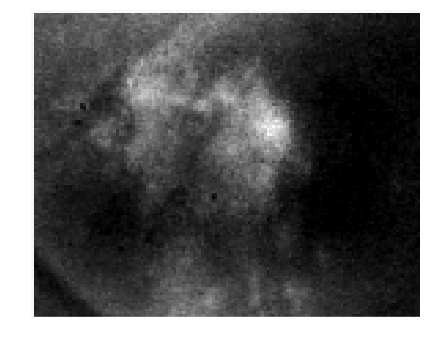

In [43]:
image(img)

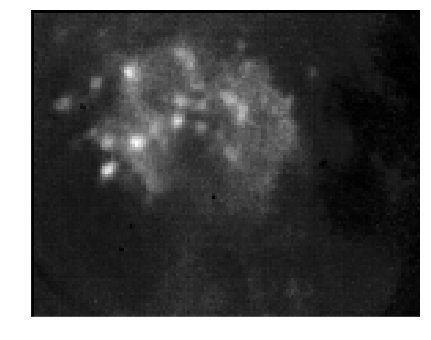

In [44]:
img = sub.stdev()
image(img[:])

In [45]:
# convert to a timeseries:
ts = sub.toSeries()
ts.cache();

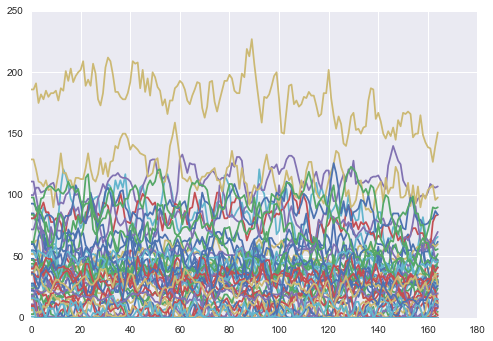

In [47]:
# Lets look at the timeseries data:
examples = ts.subset(nsamples=50, thresh=0.5)
plt.plot(examples.T);

In [48]:
#Perform KMeans clustering with 10 clusters:


from thunder import KMeans
model = KMeans(k=10).fit(ts)

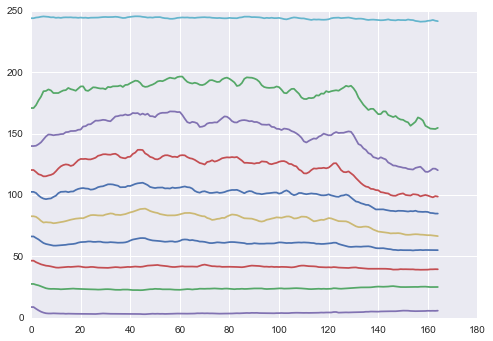

In [49]:
#Plot the time series associated with each of the recovered clusters, with a fixed but arbitrary color scheme:

from matplotlib.colors import ListedColormap
cmapCat = ListedColormap(sns.color_palette("hls", 10), name='from_list')
# plt.gca().set_color_cycle(cmapCat.colors)
plt.plot(model.centers.T);

In [50]:
#Compute a predicted label for each pixel, and collect it as an image of labels:
labels = model.predict(ts)
imgLabels = labels.pack()

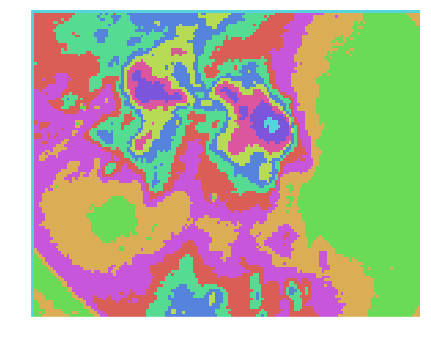

In [51]:
image(imgLabels[:,:], cmap=cmapCat)

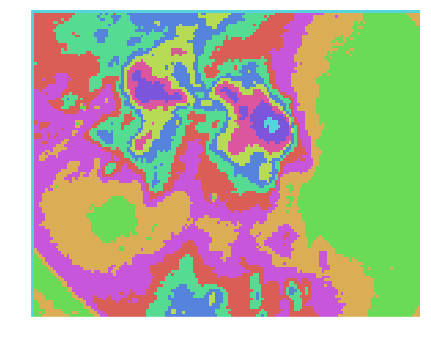

In [53]:
brainmap = Colorize(cmap=cmapCat).transform(imgLabels[:,:])
image(brainmap)

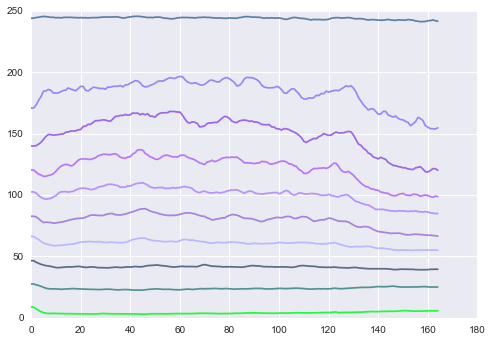

In [54]:
# The color assignments we used above were essentially an arbitrary mapping from 
# cluster center to color. When we do clustering, however, it is often the case 
# that some centers are more similar to one another, and it can be easier to interpret 
# the results if the colors are choosen based on these relative similarities. The 
# Colorize method optimize tries to find a set of colors such that similaries among colors 
# match similaries among an input array (in this case, the cluster centers). 
# The optimization is non-unique, so you can run multiple times to generate different color 
# schemes.

newClrs = Colorize.optimize(model.centers, asCmap=True)
# Note that centers that resemble one another have similar colors:

plt.gca().set_color_cycle(newClrs.colors)
plt.plot(model.centers.T);

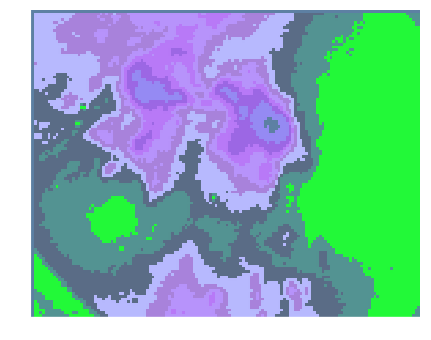

In [55]:
# And if we look at the map, we now see that similar regions are colored similarly (e.g. top and bottom), which makes the spatial organization more clear.

brainmap = Colorize(cmap=newClrs).transform(imgLabels[:,:])
image(brainmap)

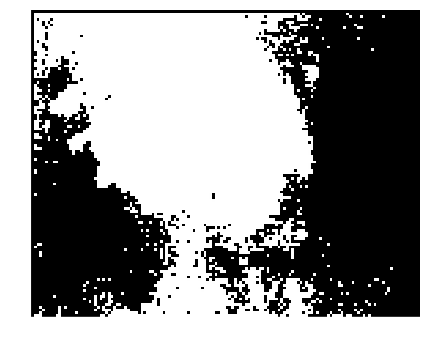

In [65]:
# One problem with what we’ve done so far is that clustering was performed on all pixels,
# but many of them were purely noise (e.g. those outside the brain), and some of the 
# resulting clusters capture these noise signals. A simple trick is to perform clustering 
# after first subselecting pixels based on the standard deviation of their time series. 
# First, let’s look at a map of the standard deviation, to find a reasonable threshold 
# that preserves most of the relavant signal, but ignores the noise.

stdMap = ts.seriesStdev().pack()
image(stdMap[:,:] > 7) # try different values of the threshold

In [66]:
from numpy import std
filtered = ts.filterOnValues(lambda x: std(x) > 7)
model = KMeans(k=10).fit(filtered)

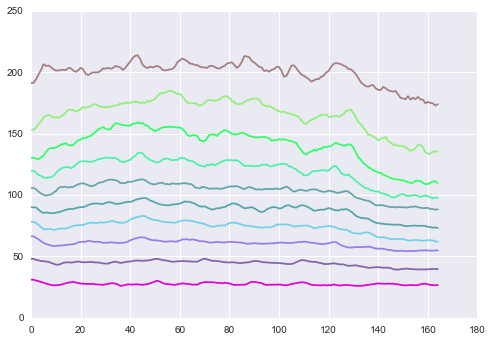

In [67]:
newClrs = Colorize.optimize(model.centers, asCmap=True)
plt.gca().set_color_cycle(newClrs.colors)
plt.plot(model.centers.T);

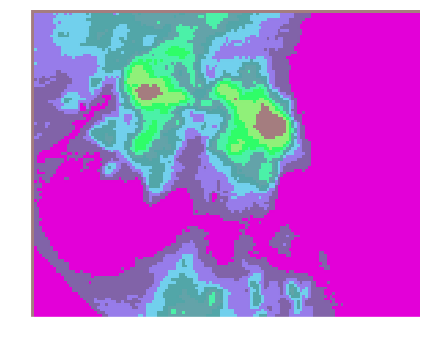

In [70]:
imgLabels = model.predict(ts).pack()
brainmap = Colorize(cmap=newClrs).transform(imgLabels[:,:])
image(brainmap)

In [71]:
## Adding similarity
# These maps are slightly odd because pixels that did not survive our threshold still 
# end up colored as something. A final useful trick is to mask pixels based on how well 
#they match the cluster they belong to. We can compute this using the similarity method 
# of KMeansModel.

sim = model.similarity(ts)
imgSim = sim.pack()

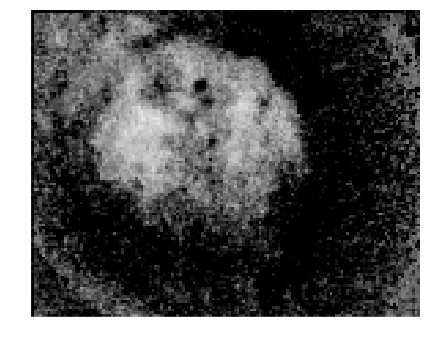

In [73]:
image(imgSim[:,:], cmap='gray', clim=(0,1))

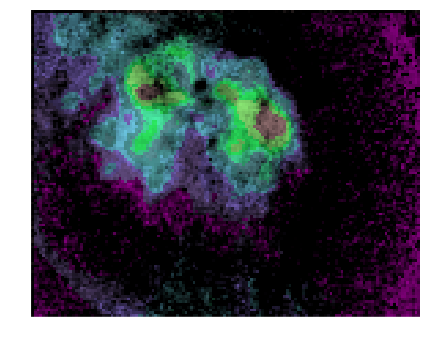

In [74]:
brainmap = Colorize(cmap=newClrs).transform(imgLabels[:,:], mask=imgSim[:,:])
image(brainmap)